In [1]:
pip install ucimlrepo

Note: you may need to restart the kernel to use updated packages.


Kształt danych: (178, 14)

Typy danych:
 Alcohol                         float64
Malicacid                       float64
Ash                             float64
Alcalinity_of_ash               float64
Magnesium                         int64
Total_phenols                   float64
Flavanoids                      float64
Nonflavanoid_phenols            float64
Proanthocyanins                 float64
Color_intensity                 float64
Hue                             float64
0D280_0D315_of_diluted_wines    float64
Proline                           int64
class                             int64
dtype: object

Czy są braki danych:
 Alcohol                         0
Malicacid                       0
Ash                             0
Alcalinity_of_ash               0
Magnesium                       0
Total_phenols                   0
Flavanoids                      0
Nonflavanoid_phenols            0
Proanthocyanins                 0
Color_intensity                 0
Hue                   

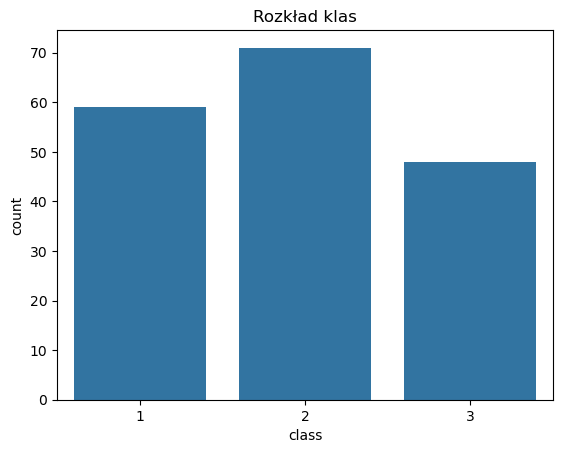

          Alcohol   Malicacid         Ash  Alcalinity_of_ash   Magnesium  \
count  178.000000  178.000000  178.000000         178.000000  178.000000   
mean    13.000618    2.336348    2.366517          19.494944   99.741573   
std      0.811827    1.117146    0.274344           3.339564   14.282484   
min     11.030000    0.740000    1.360000          10.600000   70.000000   
25%     12.362500    1.602500    2.210000          17.200000   88.000000   
50%     13.050000    1.865000    2.360000          19.500000   98.000000   
75%     13.677500    3.082500    2.557500          21.500000  107.000000   
max     14.830000    5.800000    3.230000          30.000000  162.000000   

       Total_phenols  Flavanoids  Nonflavanoid_phenols  Proanthocyanins  \
count     178.000000  178.000000            178.000000       178.000000   
mean        2.295112    2.029270              0.361854         1.590899   
std         0.625851    0.998859              0.124453         0.572359   
min         0.9

In [1]:
from ucimlrepo import fetch_ucirepo 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# fetch dataset 
wine = fetch_ucirepo(id=109) 
# data (as pandas dataframes) 
X = wine.data.features 
y = wine.data.targets
feature_names = wine.feature_names
df = pd.DataFrame(X, columns=feature_names)
df['class'] = y
print("Kształt danych:", df.shape)
print("\nTypy danych:\n", df.dtypes)
print("\nCzy są braki danych:\n", df.isnull().sum())
print("Rozkład klas:\n", df['class'].value_counts(normalize=True))
sns.countplot(data=df, x='class')
plt.title("Rozkład klas")
plt.show()
print(df.describe())

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [10]:
def confusion_matrix(y_true, y_pred, num_classes):
    cm = np.zeros((num_classes, num_classes), dtype=int)
    
    for true_label, pred_label in zip(y_true, y_pred):
       # print(f"true_label={true_label} ({type(true_label)}), pred_label={pred_label} ({type(pred_label)})")
        cm[true_label-1, pred_label-1] += 1
    return cm
    
def accuracy(y_true, y_pred):
    """Oblicza dokładność klasyfikacji."""
    return np.sum(y_true == y_pred) / len(y_true)

def precision(y_true, y_pred, average='macro'):
    """Oblicza precyzję. Obsługuje micro/macro averaging."""
    cm = confusion_matrix(y_true, y_pred, num_classes=len(np.unique(y_true)))
    
    if average == 'macro':
        precisions = []
        for i in range(cm.shape[0]):
            TP = cm[i, i]
            FP = np.sum(cm[:, i]) - TP
            precisions.append(TP / (TP + FP) if (TP + FP) != 0 else 0)
        return np.mean(precisions)
    
    elif average == 'micro':
        TP = np.sum(np.diagonal(cm))
        FP = np.sum(cm) - TP
        return TP / (TP + FP)

def recall(y_true, y_pred, average='macro'):
    """Oblicza recall. Obsługuje micro/macro averaging."""
    cm = confusion_matrix(y_true, y_pred, num_classes=len(np.unique(y_true)))
    
    if average == 'macro':
        recalls = []
        for i in range(cm.shape[0]):
            TP = cm[i, i]
            FN = np.sum(cm[i, :]) - TP
            recalls.append(TP / (TP + FN) if (TP + FN) != 0 else 0)
        return np.mean(recalls)
    
    elif average == 'micro':
        TP = np.sum(np.diagonal(cm))
        FN = np.sum(cm) - TP
        return TP / (TP + FN)

def f1_score(y_true, y_pred, average='macro'):
    """Oblicza F1-score. Obsługuje micro/macro averaging."""
    prec = precision(y_true, y_pred, average)
    rec = recall(y_true, y_pred, average)
    
    if average == 'macro':
        return 2 * (prec * rec) / (prec + rec) if (prec + rec) != 0 else 0
    
    elif average == 'micro':
        return 2 * (prec * rec) / (prec + rec) if (prec + rec) != 0 else 0

In [11]:
class KNNClassifier:
    def __init__(self, k=3, metric='euclidean',  p=2):
        self.k = k
        self.p = p
        self.metric = metric
        self.X_train = np.empty((0, 0))
        self.y_train = np.array([])  
        
    def fit(self, X_train, y_train):
        self.X_train = np.array(X_train)
        self.y_train = np.array(y_train).reshape(-1).astype(int)

    def predict(self, X_test):
        def euclidean_distance(x1, x2):
            return np.sqrt(np.sum((x1 - x2) ** 2))
        def minkowski_distance(x1, x2, p):
            return np.sum(np.abs(x1 - x2) ** p) ** (1 / p)
        
        predictions = []
        for test_point in X_test:
            if self.metric == 'minkowski':
                distances = np.array([minkowski_distance(test_point, train_point, self.p) for train_point in self.X_train])
            else:
                distances = np.array([euclidean_distance(test_point, train_point) for train_point in self.X_train])
            nearest_neighbors_indices = np.argsort(distances)[:self.k]
            nearest_labels = self.y_train[nearest_neighbors_indices]
           # print("nearest_labels:", nearest_labels, nearest_labels.shape, nearest_labels.dtype)  # debug
            most_common_label = np.bincount(nearest_labels).argmax()
            predictions.append(most_common_label)
        
        return np.array(predictions)

In [12]:
knn = KNNClassifier(k=5, metric='minkowski', p=2)
knn.fit(X_train_scaled, y_train)
y_pred_knn = knn.predict(X_test_scaled)
y_test_knn = y_test.iloc[:, 0].astype(int).values  # konwersja na 1D numpy array intów

print("KNN")
cm_knn = confusion_matrix(y_test_knn, y_pred_knn, num_classes=3)
print("Confusion matrix:\n", cm_knn)
print("Accuracy:", accuracy(y_test_knn, y_pred_knn))
print("Precision (macro):", precision(y_test_knn, y_pred_knn, average='macro'))
print("Recall (macro):", recall(y_test_knn, y_pred_knn, average='macro'))
print("F1-score (macro):", f1_score(y_test_knn, y_pred_knn, average='macro'))
print("Precision (micro):", precision(y_test_knn, y_pred_knn, average='micro'))
print("Recall (micro):", recall(y_test_knn, y_pred_knn, average='micro'))
print("F1-score (micro):", f1_score(y_test_knn, y_pred_knn, average='micro'))

KNN
Confusion matrix:
 [[12  0  0]
 [ 0 13  1]
 [ 0  0 10]]
Accuracy: 0.9722222222222222
Precision (macro): 0.9696969696969697
Recall (macro): 0.9761904761904763
F1-score (macro): 0.9729328883945124
Precision (micro): 0.9722222222222222
Recall (micro): 0.9722222222222222
F1-score (micro): 0.9722222222222222


In [16]:
class Perceptron:
    def __init__(self, learning_rate=0.01, max_iter=1000):
        self.learning_rate = learning_rate
        self.max_iter = max_iter
        self.weights = None
        self.bias = 0

    def fit(self, X_train, y_train):
        X_train = np.array(X_train)
        y_train = np.array(y_train)
        n_samples, n_features = X_train.shape
        self.weights = np.zeros(n_features)

        for _ in range(self.max_iter):
            for i in range(n_samples):
                xi = X_train[i]
                yi = y_train[i]
                linear_output = np.dot(xi, self.weights) + self.bias
                predicted_output = 1 if linear_output >= 0 else 0

                if predicted_output != yi:
                    self.weights += self.learning_rate * (yi - predicted_output) * xi
                    self.bias += self.learning_rate * (yi - predicted_output)

    def predict_proba(self, X):
        return np.dot(X, self.weights) + self.bias

    def predict(self, X):
        return np.where(self.predict_proba(X) >= 0, 1, 0)

In [17]:
 class OVRClassifier:
    def __init__(self, base_estimator_class, **kwargs):
        self.base_estimator_class = base_estimator_class
        self.kwargs = kwargs
        self.classifiers = {}

    def fit(self, X, y):
        self.classes_ = np.unique(y)

        for class_label in self.classes_:
            y_binary = (y == class_label).astype(int)
            classifier = self.base_estimator_class(**self.kwargs)
            classifier.fit(X, y_binary)

            self.classifiers[class_label] = classifier
    def predict(self, X):
        scores = {}
    
        for class_label, classifier in self.classifiers.items():
            if hasattr(classifier, "decision_function"):
                score = classifier.decision_function(X)
            elif hasattr(classifier, "predict_proba"):
                proba = classifier.predict_proba(X)
                if proba.ndim == 1:
                    score = proba
                else:
                    score = proba[:, 1]
            else:
                raise ValueError("Klasyfikator nie wspiera predict_proba ani decision_function")
    
            scores[class_label] = score
    
        all_scores = np.vstack([scores[class_label] for class_label in self.classes_]).T
        predicted_indices = np.argmax(all_scores, axis=1)
        return self.classes_[predicted_indices]

In [23]:
ovr_perceptron = OVRClassifier(Perceptron, learning_rate=0.001, max_iter=1000)
ovr_perceptron.fit(X_train_scaled, y_train)
y_pred_perc = ovr_perceptron.predict(X_test_scaled)
y_test_perc = y_test.iloc[:, 0].astype(int).values  # konwersja na 1D numpy array intów

print("Perceptron (One-vs-Rest)")
cm_perc = confusion_matrix(y_test_perc, y_pred_perc, num_classes=3)
print("Confusion matrix:\n", cm_perc)
print("Accuracy:", accuracy(y_test_perc, y_pred_perc))
print("Precision (macro):", precision(y_test_perc, y_pred_perc, average='macro'))
print("Recall (macro):", recall(y_test_perc, y_pred_perc, average='macro'))
print("F1-score (macro):", f1_score(y_test_perc, y_pred_perc, average='macro'))
print("Precision (micro):", precision(y_test_perc, y_pred_perc, average='micro'))
print("Recall (micro):", recall(y_test_perc, y_pred_perc, average='micro'))
print("F1-score (micro):", f1_score(y_test_perc, y_pred_perc, average='micro'))

Perceptron (One-vs-Rest)
Confusion matrix:
 [[12  0  0]
 [ 0 14  0]
 [ 0  1  9]]
Accuracy: 0.9722222222222222
Precision (macro): 0.9777777777777779
Recall (macro): 0.9666666666666667
F1-score (macro): 0.9721904761904762
Precision (micro): 0.9722222222222222
Recall (micro): 0.9722222222222222
F1-score (micro): 0.9722222222222222


In [26]:
from sklearn.svm import SVC
y_train_flat = y_train.values.ravel()
y_test_flat = y_test.values.ravel()
svc_ovr = OVRClassifier(SVC, kernel="linear", probability=True)
svc_ovr.fit(X_train_scaled, y_train_flat)
y_pred_svc = svc_ovr.predict(X_test_scaled)

print("SVC (sklearn OneVsRestClassifier)")
cm_svc = confusion_matrix(y_test_flat, y_pred_svc, num_classes=3)
print("Confusion matrix:\n", cm_svc)
print("Accuracy:", accuracy(y_test_flat, y_pred_svc))
print("Precision (macro):", precision(y_test_flat, y_pred_svc, average='macro'))
print("Recall (macro):", recall(y_test_flat, y_pred_svc, average='macro'))
print("F1-score (macro):", f1_score(y_test_flat, y_pred_svc, average='macro'))
print("Precision (micro):", precision(y_test_flat, y_pred_svc, average='micro'))
print("Recall (micro):", recall(y_test_flat, y_pred_svc, average='micro'))
print("F1-score (micro):", f1_score(y_test_flat, y_pred_svc, average='micro'))

SVC (sklearn OneVsRestClassifier)
Confusion matrix:
 [[12  0  0]
 [ 0 14  0]
 [ 0  2  8]]
Accuracy: 0.9444444444444444
Precision (macro): 0.9583333333333334
Recall (macro): 0.9333333333333332
F1-score (macro): 0.9456681350954478
Precision (micro): 0.9444444444444444
Recall (micro): 0.9444444444444444
F1-score (micro): 0.9444444444444444


In [27]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
rf = RandomForestClassifier(random_state=42)

param_grid = {
    'n_estimators': [50, 100, 200],  
    'max_depth': [None, 5, 10, 20],   
}

grid_search = GridSearchCV(
    rf,
    param_grid,
    cv=5,
    scoring='accuracy',   
    n_jobs=-1,           
    verbose=1
)

grid_search.fit(X_train_scaled, y_train.values.ravel())  

print("Najlepsze parametry:", grid_search.best_params_)
print("Najlepszy wynik (accuracy):", grid_search.best_score_)

best_rf = grid_search.best_estimator_
y_pred_rf = best_rf.predict(X_test_scaled)
y_test_rf = y_test.iloc[:, 0].astype(int).values  

print("Random Forest - wyniki na zbiorze testowym:")
cm_rf = confusion_matrix(y_test_rf, y_pred_rf, num_classes=3)
print("Macierz pomyłek:\n", cm_rf)
print("Accuracy:", accuracy(y_test_rf, y_pred_rf))
print("Precision (macro):", precision(y_test_rf, y_pred_rf, average='macro'))
print("Recall (macro):", recall(y_test_rf, y_pred_rf, average='macro'))
print("F1-score (macro):", f1_score(y_test_rf, y_pred_rf, average='macro'))
print("Precision (micro):", precision(y_test_rf, y_pred_rf, average='micro'))
print("Recall (micro):", recall(y_test_rf, y_pred_rf, average='micro'))
print("F1-score (micro):", f1_score(y_test_rf, y_pred_rf, average='micro'))

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Najlepsze parametry: {'max_depth': None, 'n_estimators': 50}
Najlepszy wynik (accuracy): 0.9862068965517242
Random Forest - wyniki na zbiorze testowym:
Macierz pomyłek:
 [[12  0  0]
 [ 0 14  0]
 [ 0  0 10]]
Accuracy: 1.0
Precision (macro): 1.0
Recall (macro): 1.0
F1-score (macro): 1.0
Precision (micro): 1.0
Recall (micro): 1.0
F1-score (micro): 1.0


In [28]:
from sklearn.ensemble import GradientBoostingClassifier

param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2]
}

gbc = GradientBoostingClassifier(random_state=42)

grid_search = GridSearchCV(
    estimator=gbc,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=2
)

grid_search.fit(X_train_scaled, y_train.values.ravel())

print("Najlepsze parametry:", grid_search.best_params_)
print("Najlepszy wynik (accuracy):", grid_search.best_score_)

best_gbc = grid_search.best_estimator_
y_pred_gbc = best_gbc.predict(X_test_scaled)
y_test_gbc = y_test.values.ravel()

print("Gradient Boosting - wyniki na zbiorze testowym:")
cm_gbc = confusion_matrix(y_test_gbc, y_pred_gbc, num_classes=3)
print("Macierz pomyłek:\n", cm_gbc)
print("Accuracy:", accuracy(y_test_gbc, y_pred_gbc))
print("Precision (macro):", precision(y_test_gbc, y_pred_gbc, average='macro'))
print("Recall (macro):", recall(y_test_gbc, y_pred_gbc, average='macro'))
print("F1-score (macro):", f1_score(y_test_gbc, y_pred_gbc, average='macro'))
print("Precision (micro):", precision(y_test_gbc, y_pred_gbc, average='micro'))
print("Recall (micro):", recall(y_test_gbc, y_pred_gbc, average='micro'))
print("F1-score (micro):", f1_score(y_test_gbc, y_pred_gbc, average='micro'))

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Najlepsze parametry: {'learning_rate': 0.1, 'n_estimators': 100}
Najlepszy wynik (accuracy): 0.9514778325123153
Gradient Boosting - wyniki na zbiorze testowym:
Macierz pomyłek:
 [[12  0  0]
 [ 1 13  0]
 [ 0  1  9]]
Accuracy: 0.9444444444444444
Precision (macro): 0.9505494505494506
Recall (macro): 0.942857142857143
F1-score (macro): 0.9466876710057209
Precision (micro): 0.9444444444444444
Recall (micro): 0.9444444444444444
F1-score (micro): 0.9444444444444444


In [29]:
from sklearn.ensemble import HistGradientBoostingClassifier
hgb_clf = HistGradientBoostingClassifier()

param_grid = {
    'max_iter': [50, 100, 200],   
    'max_depth': [3, 5, None] 
}

grid_search = GridSearchCV(estimator=hgb_clf, param_grid=param_grid,
                           scoring='accuracy', cv=5, n_jobs=-1)

grid_search.fit(X_train_scaled, y_train.values.ravel())  

print(f"Najlepsze parametry: {grid_search.best_params_}")
print(f"Najlepszy wynik (accuracy): {grid_search.best_score_}")

best_hgb = grid_search.best_estimator_
y_pred_hgb = best_hgb.predict(X_test_scaled)

y_test_hgb = y_test.iloc[:, 0].astype(int).values

print("HistGradientBoosting - wyniki na zbiorze testowym:")
cm_hgb = confusion_matrix(y_test_hgb, y_pred_hgb, num_classes=3)
print("Macierz pomyłek:\n", cm_hgb)
print("Accuracy:", accuracy(y_test_hgb, y_pred_hgb))
print("Precision (macro):", precision(y_test_hgb, y_pred_hgb, average='macro'))
print("Recall (macro):", recall(y_test_hgb, y_pred_hgb, average='macro'))
print("F1-score (macro):", f1_score(y_test_hgb, y_pred_hgb, average='macro'))
print("Precision (micro):", precision(y_test_hgb, y_pred_hgb, average='micro'))
print("Recall (micro):", recall(y_test_hgb, y_pred_hgb, average='micro'))
print("F1-score (micro):", f1_score(y_test_hgb, y_pred_hgb, average='micro'))

Najlepsze parametry: {'max_depth': 3, 'max_iter': 100}
Najlepszy wynik (accuracy): 0.958128078817734
HistGradientBoosting - wyniki na zbiorze testowym:
Macierz pomyłek:
 [[12  0  0]
 [ 0 14  0]
 [ 0  0 10]]
Accuracy: 1.0
Precision (macro): 1.0
Recall (macro): 1.0
F1-score (macro): 1.0
Precision (micro): 1.0
Recall (micro): 1.0
F1-score (micro): 1.0
